In [1]:
from fastai.vision.all import *

In [2]:
# create a tensor made up of floats from 0 - 20
time = torch.arange(0,20).float()
time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19.])

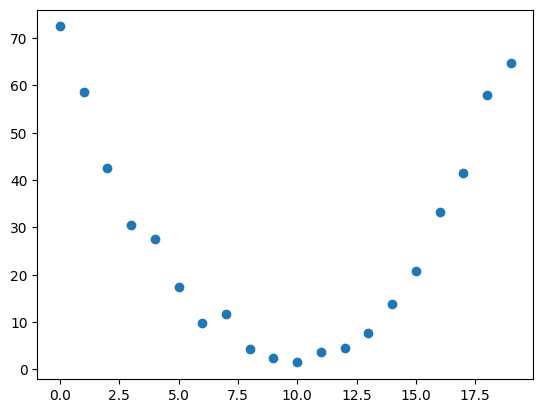

In [3]:
# torch.randn(size) creats a tensor with the shape `size` 
# https://pytorch.org/docs/stable/generated/torch.randn.html#torch.randn
# calcs a tensor with 20 random numbers, multiplied by 3
# adds these to time after some additional math done there
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time,speed);

In [4]:
# will be using a quadratic as our model formula
# a*(time**2)+(b*time)+c
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c

In [5]:
# Want to find the best quadratic function for our data
# What do we mean by `best`? Need a loss function, this will determine
# model's performance over time.
# We want to minimize the loss, we will be using Mean Squared Error

def mse(preds, targets):
    return ((preds-targets)**2).mean()

Now we can work through our step process. For a reminder:
1. *Initialize* the weights
2. Use weights to *predict* outcome
3. Based on these predictions, calculate how good the model is (its *loss*)
4. Calculate the *gradient*, which measures for each weight, how changing that weight would change the loss
5. *Step* (that is, change) all the weights based on that calculation
6. Go back to step 2, and repeat the process
7. Iterate until you decide to stop the training process

First we initialize the weights to random values and tell PyTorch that we want to track their gradients using `requires_grad`
https://pytorch.org/docs/stable/generated/torch.randn.html#torch.randn

`requires_grad`(bool, optional) - If autograd should record operations on the returned tensor. Defalt: `False`.

In [6]:
# torch.randn() api again, creates a tensor of shape 3 with
# random values. `requires_grad_()` indicates to the PyTorch api
# that autograd should record operations on this tensor to calc
# gradients

params = torch.randn(3).requires_grad_()

In [7]:
orig_params = params.clone()

In [8]:
# Calculate the predictions using the function we defined earlier
# with our quadratic formula
# Reminder: `time` is the 20 random values we created at beginning
# of notebook

preds = f(time, params)

Let's create a little function to see how close our predictions are to our targets, and take a look:

In [9]:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)

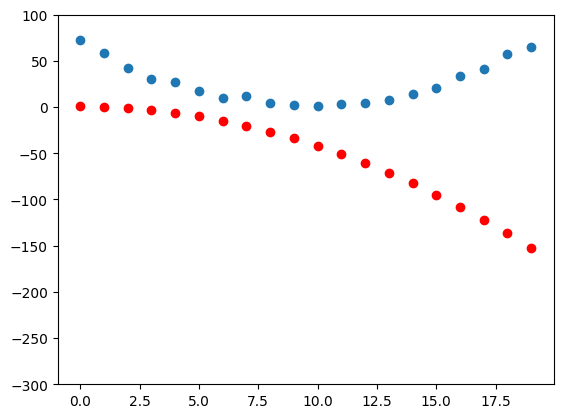

In [10]:
show_preds(preds)

Calculate the loss as follows:

In [11]:
# mse() takes in predictions and targets, and calculates the mean
# squared error between the two for every item in the tensors
# our targets in this case is the actual speed that we calculated
# using random values
loss = mse(preds, speed)
loss

tensor(9320.5879, grad_fn=<MeanBackward0>)

Our goal is to improve this, to do that we'll need to know the gradients of each parameter. So, we'll calculate them, otherwise known as an aproximation of how the parameters need to change.

In [12]:
# calling `backward()` on the loss to calculate the gradients
loss.backward()
params.grad

tensor([-31203.4375,  -2002.3004,   -155.9626])

In [14]:
# normalize the gradients
params.grad * 1e-5

tensor([-0.3120, -0.0200, -0.0016])

In [15]:
params

tensor([-0.4196, -0.0814,  0.9569], requires_grad=True)

We'll need to pick a learning rate, just using 1e-5 for now. Then, we can step our parameters using the gradients we just calculated and our learning rate.

In [17]:
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

Understanding this bit depends on remembering recent history. To calculate the gradients we call backward on the loss. But this loss was itself calculated by mse, which in turn took preds as an input, which was calculated using f taking as an input params, which was the object on which we originally called requires_grad_—which is the original call that now allows us to call backward on loss. This chain of function calls represents the mathematical composition of functions, which enables PyTorch to use calculus's chain rule under the hood to calculate these gradients.

Let's see if the loss has improved after updating the parameters.

In [19]:
preds = f(time, params)
mse(preds, speed)

tensor(2305.6453, grad_fn=<MeanBackward0>)

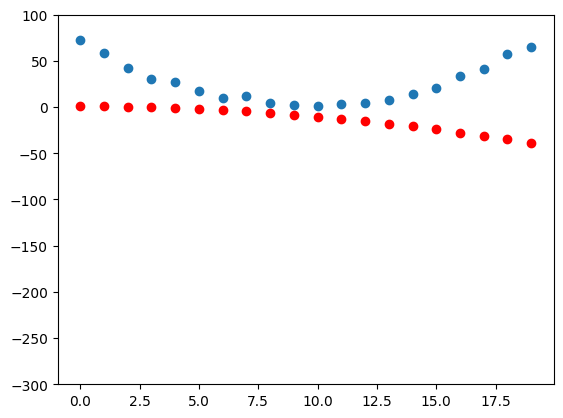

In [20]:
show_preds(preds)

It has improved! We'll want to repeat this mulitple times to continue the training process. Let's create a function to apply this:

In [21]:
def apply_step(params, prn=True):
    # calculate predictions
    preds = f(time, params)
    # calculate loss from generated predictions
    loss = mse(preds, speed)
    # calc gradients
    loss.backward()
    # update params using calculated gradients*lr (step)
    params.data -= lr * params.grad.data
    # update gradients to None
    params.grad = None
    # print loss each iteration
    if prn: print(loss.item())
    return preds

In [22]:
for i in range(10): apply_step(params)

2305.645263671875
978.2008056640625
727.0049438476562
679.4680786132812
670.4697265625
668.7642211914062
668.4385375976562
668.3739013671875
668.3588256835938
668.3530883789062


In [24]:
params = orig_params.detach().requires_grad_()
params

tensor([-0.4196, -0.0814,  0.9569], requires_grad=True)

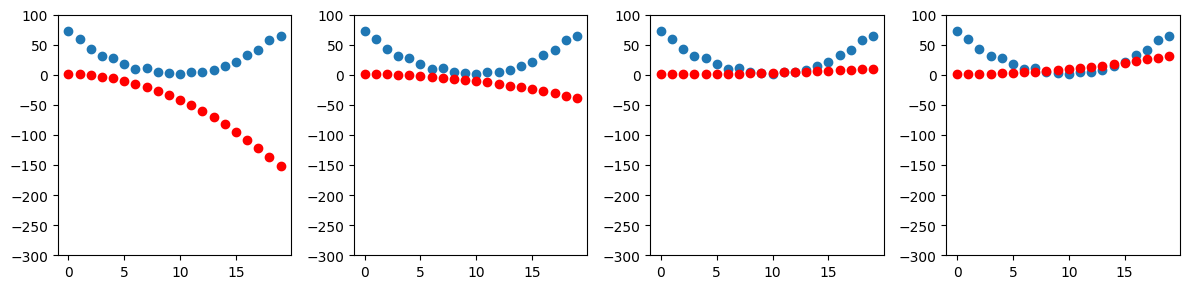

In [25]:
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

Now apply this process to the MNIST Dataset of handwritten 3's and 7's

In [27]:
# download dataset
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path

In [28]:
path.ls()

(#3) [Path('valid'),Path('labels.csv'),Path('train')]

In [29]:
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

In [30]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [40]:
# create validation set
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [31]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

We then convert these images into tensors that represent the images as an array of integers.

In [32]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


In [33]:
# create tensors with every image represented as a tensor
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

In [35]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

Concatenate all of our input images represented as tensors in a single tensor and change them from a list of matrices (rank-3 tensor) to a list of vectors (rank-2 tensor). View is part of PyTorch API and allows you to change the shape of a tensor without changing its contents.

In [36]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

Label for each image, 1 for 3's and 0 for 7's.

In [37]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

A Dataset in PyTorch is required to return a tuple of (x,y) when indexed. Python provides a zip function which, when combined with list, provides a simple way to get this functionality:

In [38]:
# combine the inputs (x) tensor with the correct answers tensor
# into a dataset
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([1]))

Create the validation set now:

In [41]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

Now we need an initially random weight for every single pixel. This is the initialize step in our 7 step process.

In [42]:
# function to return a randomized tensor of given shape
def init_params(size, std=1.0):
    return (torch.randn(size)*std).requires_grad_()

In [43]:
# create random weights for pixels
weights = init_params((28*28, 1))

In [44]:
# also need to initialize a bias
bias = init_params(1)

In neural networks, the w in the equation y=w*x+b is called the weights, and the b is called the bias. Together, the weights and bias make up the parameters.

Parameters: The weights and biases of a model. The weights are the w in the equation w*x+b, and the biases are the b in that equation.

We can now calculate a prediction for one image:

In [45]:
(train_x[0]*weights.T).sum() + bias

tensor([0.8426], grad_fn=<AddBackward0>)

This is the prediction for a single image. To train a model, we'd want a way to calculate this for every single image we have. Instead of writing a for loop to do this, which is very, very slow in Python especially with very large datasets, we will use something else.

In Python, matrix multiplication is represented with the @ operation.

In [48]:
def linear1(xb):
    return xb@weights + bias

preds = linear1(train_x)
preds

tensor([[ 0.8426],
        [ 8.0132],
        [-1.5557],
        ...,
        [ 8.0516],
        [-1.8652],
        [ 4.3713]], grad_fn=<AddBackward0>)

Notice we are using a linear model here for the MNIST dataset and were using a quadratic function for the original test dataset.

This equation, batch@weights + bias, is one of the two fundamental equations of any neural network (the other one is the activation function, which we'll see in a moment).

We can check our accuract of the model by comparing its predictions with the actual answers. To decide if an output represents a 3 or 7, we can just check where it's greater thatn 0.0, so our accuracy for each item can be calculated (using broadcasting, so no loops!) with:

In [49]:
corrects = (preds>0.0).float() == train_y
corrects

tensor([[ True],
        [ True],
        [False],
        ...,
        [False],
        [ True],
        [False]])

In [50]:
corrects.float().mean().item()

0.4966118037700653

Now, we'd like to calculate the loss of our model. With the loss we can calculate the gradients and then use that information to step our parameters and improve the model, repeatedly.

To do this, we'll create two new variables `prds` and `trgts` as tensors. `prds` will contain values between 0 and 1, `trgts` will contain either 0 or 1 and will indicate if an image is actually a 3 or not.

In [51]:
# test
trgts  = tensor([1,0,1])
prds   = tensor([0.9, 0.4, 0.2])

Loss funtion (similar to the original mse() function) that measures the distance between `predictions` and `targets`.

In [52]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

`mnist_loss` measures how distant each prediction is from 1 if it should be, and how distant it is from 0 i fit should be 0, and then it will take the mean of all those distances.

We're using a new function, torch.where(a,b,c). This is the same as running the list comprehension [b[i] if a[i] else c[i] for i in range(len(a))], except it works on tensors, at C/CUDA speed. Try running help(torch.where) now to read the docs for this function, or, better still, look it up on the PyTorch documentation site.

https://pytorch.org/docs/stable/generated/torch.where.html#torch.where

`torch.where`: Return a tensor of elements selected from either input or other, depending on condition.

In [53]:
help(torch.where)

Help on built-in function where in module torch:

where(...)
    where(condition, input, other, *, out=None) -> Tensor
    
    Return a tensor of elements selected from either :attr:`input` or :attr:`other`, depending on :attr:`condition`.
    
    The operation is defined as:
    
    .. math::
        \text{out}_i = \begin{cases}
            \text{input}_i & \text{if } \text{condition}_i \\
            \text{other}_i & \text{otherwise} \\
        \end{cases}
    
    .. note::
        The tensors :attr:`condition`, :attr:`input`, :attr:`other` must be :ref:`broadcastable <broadcasting-semantics>`.
    
    Arguments:
        condition (BoolTensor): When True (nonzero), yield input, otherwise yield other
        input (Tensor or Scalar): value (if :attr:`input` is a scalar) or values selected at indices
                              where :attr:`condition` is ``True``
        other (Tensor or Scalar): value (if :attr:`other` is a scalar) or values selected at indices
                

In [54]:
# try it on our test data
torch.where(trgts==1, 1-prds, prds)

tensor([0.1000, 0.4000, 0.8000])

In [55]:
# we need a scalar (singular) value of the loss, so the mnist_loss
# function takes the average of all of the losses
mnist_loss(prds,trgts)

tensor(0.4333)

In [56]:
# test with new data
mnist_loss(tensor([0.9, 0.4, 0.8]),trgts)

tensor(0.2333)

The `mnist_loss` function does assume all predictions are always between 0 and 1. We can enforce this by incorporating a sigmoid function.

In [57]:
def sigmoid(x):
    return 1/(1+torch.exp(-x))

Pytorch defines an accelerated version for us, so we don’t really need our own. This is an important function in deep learning, since we often want to ensure values are between 0 and 1. This is what it looks like:

In [58]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

NameError: name 'plot_function' is not defined

Update `mnist_loss` to first apply `sigmoid` to the inputs:

In [59]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

Now, we can train a model. Will use mini-batches to train and update the parameters each epoch with a mini-batch.

A Fastai `DataLoader` can take any Python collection and turn it into an iterator over mini-batches, like so:

In [60]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 6, 14, 12,  0, 11]),
 tensor([7, 8, 5, 3, 1]),
 tensor([13,  4,  9, 10,  2])]

For training a model, we don't just want any Python collection, but a collection containing independent and dependent variables (that is, the inputs and targets of the model). A collection that contains tuples of independent and dependent variables is known in PyTorch as a Dataset. Here's an example of an extremely simple Dataset:

In [61]:
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

When we pass a `Dataset` to a `DataLoader` we will get back mini-batches which are themselves tuples of tensors representing batches of independent and dependent variables:

In [62]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([13,  4, 16,  1, 11, 12]), ('n', 'e', 'q', 'b', 'l', 'm')),
 (tensor([ 0, 20, 21,  6,  3, 19]), ('a', 'u', 'v', 'g', 'd', 't')),
 (tensor([25,  7, 17, 24,  2,  5]), ('z', 'h', 'r', 'y', 'c', 'f')),
 (tensor([14,  8,  9, 10, 18, 23]), ('o', 'i', 'j', 'k', 's', 'x')),
 (tensor([22, 15]), ('w', 'p'))]

First, let's re-initialize our parameters:

In [63]:
weights = init_params((28*28, 1))
bias = init_params(1)

A DataLoader can be created from a Dataset:

In [64]:
# we created dset a bit ago by combining the inputs and outputs tensors
dl = DataLoader(dset, bdatch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

Do the same for the validation set:

In [65]:
valid_dl = DataLoader(valid_dset, batch_size=256)

Let's create a mini-batch of size 4 for testing:

In [66]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [67]:
preds = linear1(batch)
preds

tensor([[-24.6989],
        [-16.9982],
        [-18.3754],
        [-13.8518]], grad_fn=<AddBackward0>)

In [68]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(1.0000, grad_fn=<MeanBackward0>)

Now we can calculate the gradients:

In [69]:
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad

(torch.Size([784, 1]), tensor(-4.4252e-08), tensor([-2.5408e-07]))

In [70]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [71]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-8.8504e-08), tensor([-5.0817e-07]))

In [72]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-1.3276e-07), tensor([-7.6225e-07]))

The gradients have changed! The reason for this is that loss.backward actually adds the gradients of loss to any gradients that are currently stored. So, we have to set the current gradients to 0 first:

In [73]:
weights.grad.zero_()
bias.grad.zero_();

note: Inplace Operations: Methods in PyTorch whose names end in an underscore modify their objects in place. For instance, bias.zero_() sets all elements of the tensor bias to 0.

In [74]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [75]:
(preds>0.0).float() == train_y[:4]

tensor([[False],
        [False],
        [False],
        [False]])

In [76]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [77]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(0.)

In [78]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [79]:
validate_epoch(linear1)

0.4743

In [80]:
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.5477

In [81]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.7875 0.8895 0.9159 0.9315 0.9418 0.9476 0.9496 0.955 0.9574 0.9579 0.9608 0.9628 0.9628 0.9632 0.9647 0.9647 0.9662 0.9676 0.9691 0.9696 

We can replace our `linear1()` function with PyTorch's `nn.Linear` module. A module is an object of a class that inherits from the PyTorch `nn.Module` class. Objects of this class behave identically to standard Python functions, in that you can call them using parentheses and they will return the activations of a model.

nn.Linear does the same thing as our init_params and linear together. It contains both the weights and biases in a single class. Here's how we replicate our model from the previous section:

In [82]:
linear_model = nn.Linear(28*28,1)

Every PyTorch module knows what parameters it has that can be trained; they are available through the parameters method:

In [83]:
w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

We can use this information to create an optimizer:

In [85]:
class BasicOptim:
    # initialize params and learning rate
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    # step model by updating params w.r.t. gradients and lr
    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    # zero out param gradients
    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

In [86]:
# create optimizer by passing in the model's parameters
opt = BasicOptim(linear_model.parameters(), lr)

Our training loop can now be simplified to:

In [87]:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [88]:
# validation function doesn't need to change at all
validate_epoch(linear_model)

0.4163

In [89]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [90]:
train_model(linear_model, 20)

0.4932 0.8618 0.8271 0.9111 0.9321 0.9453 0.955 0.9623 0.9658 0.9672 0.9692 0.9716 0.9731 0.975 0.9755 0.976 0.9775 0.9775 0.978 0.9785 

`fastai` provides the SGD class which, by default, does the same thing as our `BasicOptim`:

In [91]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.7827 0.8588 0.9174 0.935 0.9502 0.9575 0.9633 0.9662 0.9682 0.9697 0.9726 0.9736 0.9745 0.976 0.9775 0.9775 0.9775 0.978 0.9785 

`fastai` also provides `Learner.fit`, which we can use instead of `train_model`. To create a Learner we first need to create a DataLoaders, by passing in our training and validation DataLoaders:

In [92]:
dls = DataLoaders(dl, valid_dl)

In [93]:
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
               loss_func=mnist_loss, metrics=batch_accuracy)

In [94]:
learn.fit(10, lr=lr)

/opt/conda/lib/python3.10/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


epoch,train_loss,valid_loss,batch_accuracy,time
0,0.637230,0.503442,0.495584,00:00
1,0.516327,0.166441,0.868499,00:00
2,0.189412,0.188008,0.830716,00:00
3,0.083203,0.109527,0.910206,00:00
4,0.044095,0.079296,0.931305,00:00
5,0.028833,0.063197,0.947498,00:00
6,0.022556,0.053245,0.954858,00:00
7,0.019760,0.046670,0.961727,00:00
8,0.018341,0.042074,0.965653,00:00
9,0.017490,0.038699,0.966634,00:00


As you can see, there's nothing magic about the PyTorch and fastai classes. They are just convenient pre-packaged pieces that make your life a bit easier! (They also provide a lot of extra functionality we'll be using in future chapters.)

With these classes, we can now replace our linear model with a neural network.

So far we have a general procedure for optimizing the parameters of a function, and we have tried it out on a very boring function: a simple linear classifier. A linear classifier is very constrained in terms of what it can do. To make it a bit more complex (and able to handle more tasks), we need to add something nonlinear between two linear classifiers—this is what gives us a neural network.

In [96]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [97]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [98]:
learn.fit(40, 0.1)

/opt/conda/lib/python3.10/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


epoch,train_loss,valid_loss,batch_accuracy,time
0,0.272219,0.414701,0.505397,00:00
1,0.132550,0.216117,0.819921,00:00
2,0.075761,0.111486,0.918548,00:00
3,0.051290,0.076172,0.943081,00:00
4,0.039696,0.059738,0.956820,00:00
5,0.033608,0.050496,0.963690,00:00
6,0.030013,0.044640,0.965653,00:00
7,0.027620,0.040623,0.966634,00:00
8,0.025866,0.037685,0.968106,00:00
9,0.024495,0.035427,0.970559,00:00


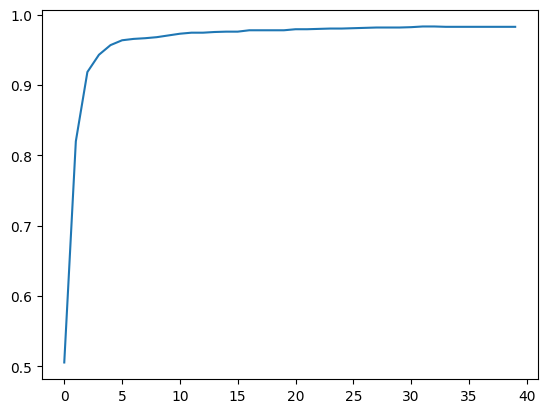

In [99]:
# plot accuracy over training
plt.plot(L(learn.recorder.values).itemgot(2));

In [100]:
# view final accuracy
learn.recorder.values[-1][2]

0.982826292514801